# 쇼핑 모델링 최종(1년)

## 라이브러리 호출

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

#한글폰트 가져오기
from matplotlib import rc
rc('font', family='NanumGothic')

# Warning 메세지를 뜨지 않게 해줌
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

#평가
from sklearn.metrics import confusion_matrix, jaccard_score
from itertools import combinations

#NLP
import nltk
from nltk.corpus import stopwords
import re

## train 데이터 불러오기

In [2]:
train = pd.read_csv('./data/Online Retail_2009.csv')

#pivot_CS
df_CS = pd.DataFrame(train.loc[:,['CustomerID','StockCode']].value_counts())
df_CS[0] = 1
pivot_CS = df_CS.pivot_table(0, index='CustomerID',columns='StockCode')
pivot_CS.fillna(0,inplace=True)

#paris_CI 생성
pairs_CI = train[['CustomerID','InvoiceNo']].groupby('CustomerID')['InvoiceNo'].apply(lambda x: x.unique())

#paris_SD 생성
pairs_SD = train.loc[:,['StockCode','Description']].groupby('StockCode')['Description'].apply(lambda x: x.unique())

## test 데이터 불러오기

In [3]:
test = pd.read_csv('./data/Online Retail_df.csv')
test['InvoiceDate'] = pd.to_datetime(test['InvoiceDate'])

# 'InvoiceDate' 열이 '2011-11-30' 이전인 데이터만 선택
test = test[test['InvoiceDate'] < '2011-12-01']

#pivot_test
df_CS_test = pd.DataFrame(test.loc[:,['CustomerID','StockCode']].value_counts())
df_CS_test['count'] = 1
pivot_test = df_CS_test.pivot_table('count', index='CustomerID',columns='StockCode')
pivot_test.fillna(0,inplace=True)

## 함수생성

### InvoiceNo_to_CustomerID
InvoiceNo - StockCode 형태를 CustomerID - StockCode형태로 변환

In [4]:
def InvoiceNo_to_CustomerID(Pred_IS, pairs_CI = pairs_CI):
    #빈객체 생성
    merged_data = []
    CustomerID_list = []
    #CustomerID와 InvoiceNo를 각각 저장해 루프 생성
    for CustomerID, invoice_list in pairs_CI.items():
        #같은 CutomerID 예측 값만 추출해 저장
        customer_data = Pred_IS[Pred_IS.index.isin(invoice_list)] 
        merged_data.append(customer_data.mean(axis=0)) #값들을 모두 합해 새로운 객체에 저장
        CustomerID_list.append(CustomerID)
    merged_data = pd.DataFrame(merged_data,index=CustomerID_list,columns=Pred_IS.columns)
    return merged_data

### get_topsim
top_n개의 유사도 외에는 다 0으로 만들어 가중치가 없도록 변환

In [5]:
def get_topsim(sim_df, top_n=20):
    sim_topn = sim_df.copy()
    for col in range(sim_df.shape[1]):
        col_sim = sim_df.iloc[:,col]
        top_n_items = [np.argsort(col_sim)[:-top_n]]
        sim_topn.iloc[top_n_items,col] = 0
    return sim_topn

### predict_count
행렬곱을 통해 데이터 프레임 형태로 반환

In [6]:
def predict_count(pivot, sim_df, IS = False):
    count_pred = pivot.T.values.dot(sim_df.values) / np.array([np.abs(sim_df.values).sum(axis=1)])
    count_pred = pd.DataFrame(count_pred, index=pivot.columns, columns=pivot.index)
    count_pred = count_pred.T
    if IS:
        count_pred = InvoiceNo_to_CustomerID(count_pred)
    return count_pred

### recomm_model
구매하지 않은 상품기준
- 고객별 구매하지 않은 상품 리스트
- 고객별 추천 상품(StockCode)
- 혼동행렬
- 정밀도

In [7]:
def recomm_model(pred_df, recomm_n = 10, pivot_CS = pivot_CS):
    unbought_df = []
    recomm_prod_df = []
    total_conf_matrix = np.matrix([[0,0],[0,0]])
    shared_customers = set(train['CustomerID'].unique()).intersection(set(test['CustomerID'].unique())) 
    for CustomerID in shared_customers:
        #구매하지 않은 상품 추출
        Customer_info = pivot_CS.loc[CustomerID,]
        unbought_list = Customer_info[Customer_info==0].index
        unbought_df.append({'CustomerID': CustomerID, 'Unbought_Items': unbought_list})

        #pred_df를 기반, 구매하지 않은 상품 중 상위 10개 추천
        recomm_prod = pred_df.loc[CustomerID, unbought_list].sort_values(ascending=False)[:recomm_n].index
        recomm_prod_df.append({'CustomerID': CustomerID, 'recommend_products': recomm_prod})

        #평가
        y_test = pd.Series(np.zeros(len(recomm_prod)))
        for index, value in enumerate(recomm_prod):
            if value in pivot_test.columns:
                y_test[index] = pivot_test.loc[CustomerID, value]
        y_pred = pd.Series(np.ones(len(recomm_prod)))
        conf_matrix = confusion_matrix(y_test, y_pred) # 혼동 행렬 계산
        if (conf_matrix[0,0] != 0):
            print('<전부 구매함>', f'\nCustomerID: {CustomerID}', f'\nprodcuct: {recomm_prod}')
            total_conf_matrix = total_conf_matrix + [[0,0],[0,conf_matrix[0,0]]]
        else:
            total_conf_matrix = total_conf_matrix + conf_matrix
    unbought_df = pd.DataFrame(unbought_df)
    recomm_prod_df = pd.DataFrame(recomm_prod_df)

    TN = total_conf_matrix[0,0]
    FP = total_conf_matrix[0,1]
    FN = total_conf_matrix[1,0]
    TP = total_conf_matrix[1,1]

    precision = np.round(TP / (TP + FP), 4) # 정밀도 계산

    evaluation = {'정밀도': precision}    
    return unbought_df, recomm_prod_df, total_conf_matrix, evaluation

## 추천 수 설정

In [8]:
recomm_n = 12

## 주문유사도 기반 추천

In [9]:
#주문별 상품 종류 데이터 프레임 생성
df_IS = pd.DataFrame(train[['InvoiceNo','StockCode']].value_counts())
df_IS['count'] = 1

#피봇형태로 변환
pivot_IS = df_IS.pivot_table('count', index='InvoiceNo',columns='StockCode')
pivot_IS.fillna(0, inplace=True)

#유사도 계산
sim_Inv = pd.DataFrame(cosine_similarity(pivot_IS),index=pivot_IS.index, columns=pivot_IS.index)

### 50개 단위

In [14]:
Inv_param_50 = []

print(recomm_n,'개 추천')
for i in range(50,18151,50):
    pred = predict_count(pivot_IS, get_topsim(sim_Inv, top_n=i), IS = True)
    result = recomm_model(pred, recomm_n=recomm_n)
    Inv_param_50.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도',max(Inv_param_50, key=lambda x: x[2]['정밀도']))
Inv_param_50

12 개 추천
최대 정밀도 [400, '개의 유사도를 반영할 때', {'정밀도': 0.1175}]


[[50, '개의 유사도를 반영할 때', {'정밀도': 0.1068}],
 [100, '개의 유사도를 반영할 때', {'정밀도': 0.1127}],
 [150, '개의 유사도를 반영할 때', {'정밀도': 0.1143}],
 [200, '개의 유사도를 반영할 때', {'정밀도': 0.1152}],
 [250, '개의 유사도를 반영할 때', {'정밀도': 0.116}],
 [300, '개의 유사도를 반영할 때', {'정밀도': 0.1167}],
 [350, '개의 유사도를 반영할 때', {'정밀도': 0.1166}],
 [400, '개의 유사도를 반영할 때', {'정밀도': 0.1175}],
 [450, '개의 유사도를 반영할 때', {'정밀도': 0.1165}],
 [500, '개의 유사도를 반영할 때', {'정밀도': 0.1161}],
 [550, '개의 유사도를 반영할 때', {'정밀도': 0.1167}],
 [600, '개의 유사도를 반영할 때', {'정밀도': 0.1162}],
 [650, '개의 유사도를 반영할 때', {'정밀도': 0.1161}],
 [700, '개의 유사도를 반영할 때', {'정밀도': 0.1158}],
 [750, '개의 유사도를 반영할 때', {'정밀도': 0.1157}],
 [800, '개의 유사도를 반영할 때', {'정밀도': 0.1157}],
 [850, '개의 유사도를 반영할 때', {'정밀도': 0.115}],
 [900, '개의 유사도를 반영할 때', {'정밀도': 0.1152}],
 [950, '개의 유사도를 반영할 때', {'정밀도': 0.1148}],
 [1000, '개의 유사도를 반영할 때', {'정밀도': 0.1144}],
 [1050, '개의 유사도를 반영할 때', {'정밀도': 0.1143}],
 [1100, '개의 유사도를 반영할 때', {'정밀도': 0.1142}],
 [1150, '개의 유사도를 반영할 때', {'정밀도': 0.1135}],
 [1200, '개의 유사도를 반영할 때', {'정밀도': 

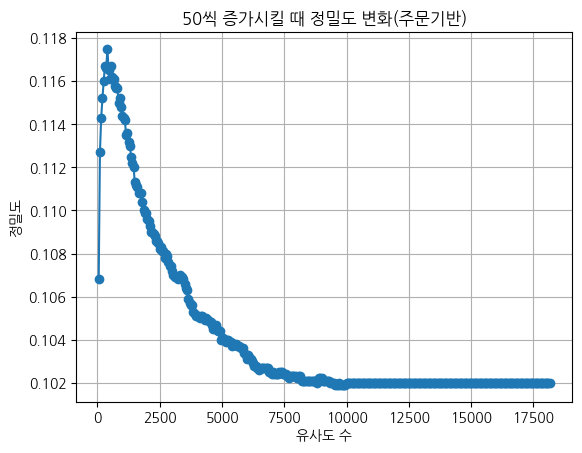

주문기반 최대 정밀도
400 개의 유사도를 반영할 때 정밀도: 0.1175


In [15]:
x = [entry[0] for entry in Inv_param_50]
y = [entry[2]['정밀도'] for entry in Inv_param_50]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('50씩 증가시킬 때 정밀도 변화(주문기반)')
plt.xlabel('유사도 수')
plt.ylabel('정밀도')

# 그래프 표시
plt.grid(True)
plt.show()

print('주문기반 최대 정밀도')
print(x[np.argsort(y)[-1]],'개의 유사도를 반영할 때 정밀도:',max(y))

### 350~450개

In [17]:
Inv_param = []

print(recomm_n,'개 추천')
for i in range(350,451):
    pred = predict_count(pivot_IS, get_topsim(sim_Inv, top_n=i), IS = True)
    result = recomm_model(pred, recomm_n=recomm_n)
    Inv_param.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도', max(Inv_param, key=lambda x: x[2]['정밀도']))
Inv_param

12 개 추천
최대 정밀도 [417, '개의 유사도를 반영할 때', {'정밀도': 0.1179}]


[[350, '개의 유사도를 반영할 때', {'정밀도': 0.1166}],
 [351, '개의 유사도를 반영할 때', {'정밀도': 0.1164}],
 [352, '개의 유사도를 반영할 때', {'정밀도': 0.1163}],
 [353, '개의 유사도를 반영할 때', {'정밀도': 0.1165}],
 [354, '개의 유사도를 반영할 때', {'정밀도': 0.1165}],
 [355, '개의 유사도를 반영할 때', {'정밀도': 0.1165}],
 [356, '개의 유사도를 반영할 때', {'정밀도': 0.1167}],
 [357, '개의 유사도를 반영할 때', {'정밀도': 0.1167}],
 [358, '개의 유사도를 반영할 때', {'정밀도': 0.1168}],
 [359, '개의 유사도를 반영할 때', {'정밀도': 0.1168}],
 [360, '개의 유사도를 반영할 때', {'정밀도': 0.1169}],
 [361, '개의 유사도를 반영할 때', {'정밀도': 0.1168}],
 [362, '개의 유사도를 반영할 때', {'정밀도': 0.1171}],
 [363, '개의 유사도를 반영할 때', {'정밀도': 0.1169}],
 [364, '개의 유사도를 반영할 때', {'정밀도': 0.1168}],
 [365, '개의 유사도를 반영할 때', {'정밀도': 0.1173}],
 [366, '개의 유사도를 반영할 때', {'정밀도': 0.1168}],
 [367, '개의 유사도를 반영할 때', {'정밀도': 0.1166}],
 [368, '개의 유사도를 반영할 때', {'정밀도': 0.1168}],
 [369, '개의 유사도를 반영할 때', {'정밀도': 0.1169}],
 [370, '개의 유사도를 반영할 때', {'정밀도': 0.1171}],
 [371, '개의 유사도를 반영할 때', {'정밀도': 0.1168}],
 [372, '개의 유사도를 반영할 때', {'정밀도': 0.1167}],
 [373, '개의 유사도를 반영할 때', {'정밀도': 0.

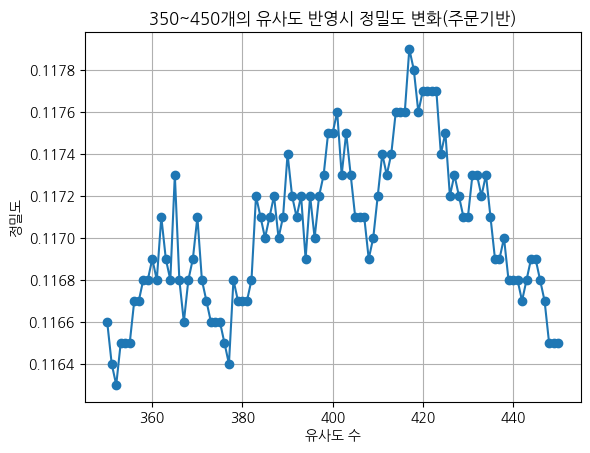

주문기반 최대 정밀도
417 개의 유사도를 반영할 때 정밀도: 0.1179


In [18]:
x = [entry[0] for entry in Inv_param]
y = [entry[2]['정밀도'] for entry in Inv_param]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('350~450개의 유사도 반영시 정밀도 변화(주문기반)')
plt.xlabel('유사도 수')
plt.ylabel('정밀도')

# 그래프 표시
plt.grid(True)
plt.show()

print('주문기반 최대 정밀도')
print(x[np.argsort(y)[-1]],'개의 유사도를 반영할 때 정밀도:',max(y))

## 고객유사도 기반 추천

### RFM 계산, scaling

In [10]:
RFM = train.copy()
RFM['InvoiceDate'] = pd.to_datetime(RFM['InvoiceDate']) #datetime 형식으로 변환
RFM['TotalPrice'] = RFM['Quantity'] * RFM['UnitPrice']

current_date = pd.Timestamp(RFM['InvoiceDate'].max()) + pd.Timedelta(days=1)
df_RFM = RFM.groupby('CustomerID').agg({
    'InvoiceDate' : (lambda x: (current_date - x.max()).days), # R
    'InvoiceNo' : 'count', # F
    'TotalPrice' : 'sum' # M
}) 

RFM_Scaler = MinMaxScaler()
df_RFM_scaled = RFM_Scaler.fit_transform(df_RFM)
df_RFM_scaled = pd.DataFrame(df_RFM_scaled, index =df_RFM.index, columns=df_RFM.columns )


In [11]:
df_CS = pd.DataFrame(train.loc[:,['CustomerID','StockCode']].value_counts())
df_CS['count'] = 1

pivot_CS = df_CS.pivot_table('count', index='CustomerID',columns='StockCode')
pivot_CS.fillna(0,inplace=True)

sim_Cust = pd.DataFrame(cosine_similarity(df_RFM_scaled),index=df_RFM_scaled.index, columns=df_RFM_scaled.index)

### 50개 단위

In [22]:
Cust_param_50 = []

print(recomm_n,'개 추천')
for i in range(50,4201,50):
    pred = predict_count(pivot_CS, get_topsim(sim_Cust, top_n=i))
    result = recomm_model(pred, recomm_n=recomm_n)
    Cust_param_50.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도', max(Cust_param_50, key=lambda x: x[2]['정밀도']))
Cust_param_50

12 개 추천
최대 정밀도 [400, '개의 유사도를 반영할 때', {'정밀도': 0.0762}]


[[50, '개의 유사도를 반영할 때', {'정밀도': 0.0684}],
 [100, '개의 유사도를 반영할 때', {'정밀도': 0.071}],
 [150, '개의 유사도를 반영할 때', {'정밀도': 0.0736}],
 [200, '개의 유사도를 반영할 때', {'정밀도': 0.0744}],
 [250, '개의 유사도를 반영할 때', {'정밀도': 0.0755}],
 [300, '개의 유사도를 반영할 때', {'정밀도': 0.0754}],
 [350, '개의 유사도를 반영할 때', {'정밀도': 0.0761}],
 [400, '개의 유사도를 반영할 때', {'정밀도': 0.0762}],
 [450, '개의 유사도를 반영할 때', {'정밀도': 0.076}],
 [500, '개의 유사도를 반영할 때', {'정밀도': 0.0756}],
 [550, '개의 유사도를 반영할 때', {'정밀도': 0.0747}],
 [600, '개의 유사도를 반영할 때', {'정밀도': 0.075}],
 [650, '개의 유사도를 반영할 때', {'정밀도': 0.0749}],
 [700, '개의 유사도를 반영할 때', {'정밀도': 0.076}],
 [750, '개의 유사도를 반영할 때', {'정밀도': 0.0757}],
 [800, '개의 유사도를 반영할 때', {'정밀도': 0.0751}],
 [850, '개의 유사도를 반영할 때', {'정밀도': 0.0749}],
 [900, '개의 유사도를 반영할 때', {'정밀도': 0.0748}],
 [950, '개의 유사도를 반영할 때', {'정밀도': 0.075}],
 [1000, '개의 유사도를 반영할 때', {'정밀도': 0.0748}],
 [1050, '개의 유사도를 반영할 때', {'정밀도': 0.0752}],
 [1100, '개의 유사도를 반영할 때', {'정밀도': 0.0753}],
 [1150, '개의 유사도를 반영할 때', {'정밀도': 0.0751}],
 [1200, '개의 유사도를 반영할 때', {'정밀도': 0.0

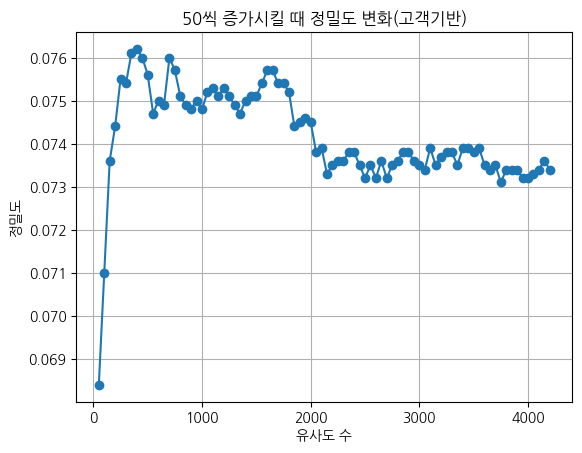

고객기반 최대 정밀도
400 개의 유사도를 반영할 때 정밀도: 0.0762


In [23]:
x = [entry[0] for entry in Cust_param_50]
y = [entry[2]['정밀도'] for entry in Cust_param_50]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('50씩 증가시킬 때 정밀도 변화(고객기반)')
plt.xlabel('유사도 수')
plt.ylabel('정밀도')

# 그래프 표시
plt.grid(True)
plt.show()

print('고객기반 최대 정밀도')
print(x[np.argsort(y)[-1]],'개의 유사도를 반영할 때 정밀도:',max(y))

### 350~450개

In [25]:
Cust_param = []

print(recomm_n,'개 추천')
for i in range(350,451):
    pred = predict_count(pivot_CS, get_topsim(sim_Cust, top_n=i))
    result = recomm_model(pred, recomm_n=recomm_n)
    Cust_param.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도', max(Cust_param, key=lambda x: x[2]['정밀도']))
Cust_param

12 개 추천
최대 정밀도 [396, '개의 유사도를 반영할 때', {'정밀도': 0.0764}]


[[350, '개의 유사도를 반영할 때', {'정밀도': 0.0761}],
 [351, '개의 유사도를 반영할 때', {'정밀도': 0.0759}],
 [352, '개의 유사도를 반영할 때', {'정밀도': 0.076}],
 [353, '개의 유사도를 반영할 때', {'정밀도': 0.0758}],
 [354, '개의 유사도를 반영할 때', {'정밀도': 0.0757}],
 [355, '개의 유사도를 반영할 때', {'정밀도': 0.0754}],
 [356, '개의 유사도를 반영할 때', {'정밀도': 0.0757}],
 [357, '개의 유사도를 반영할 때', {'정밀도': 0.0759}],
 [358, '개의 유사도를 반영할 때', {'정밀도': 0.0763}],
 [359, '개의 유사도를 반영할 때', {'정밀도': 0.0763}],
 [360, '개의 유사도를 반영할 때', {'정밀도': 0.0762}],
 [361, '개의 유사도를 반영할 때', {'정밀도': 0.0759}],
 [362, '개의 유사도를 반영할 때', {'정밀도': 0.0758}],
 [363, '개의 유사도를 반영할 때', {'정밀도': 0.0758}],
 [364, '개의 유사도를 반영할 때', {'정밀도': 0.0755}],
 [365, '개의 유사도를 반영할 때', {'정밀도': 0.0759}],
 [366, '개의 유사도를 반영할 때', {'정밀도': 0.0758}],
 [367, '개의 유사도를 반영할 때', {'정밀도': 0.0757}],
 [368, '개의 유사도를 반영할 때', {'정밀도': 0.0756}],
 [369, '개의 유사도를 반영할 때', {'정밀도': 0.0755}],
 [370, '개의 유사도를 반영할 때', {'정밀도': 0.0755}],
 [371, '개의 유사도를 반영할 때', {'정밀도': 0.0757}],
 [372, '개의 유사도를 반영할 때', {'정밀도': 0.0758}],
 [373, '개의 유사도를 반영할 때', {'정밀도': 0.0

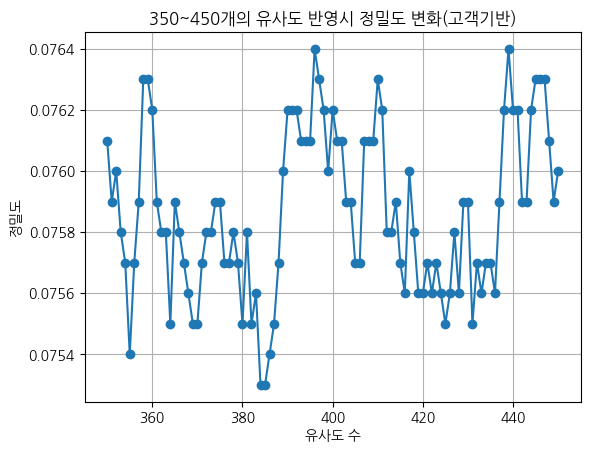

고객기반 최대 정밀도
396 개의 유사도를 반영할 때 정밀도: 0.0764


In [26]:
x = [entry[0] for entry in Cust_param]
y = [entry[2]['정밀도'] for entry in Cust_param]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('350~450개의 유사도 반영시 정밀도 변화(고객기반)')
plt.xlabel('유사도 수')
plt.ylabel('정밀도')

# 그래프 표시
plt.grid(True)
plt.show()

print('고객기반 최대 정밀도')
print(x[np.argsort(y)[-1]],'개의 유사도를 반영할 때 정밀도:',max(y))

## 아이템 유사도 기반

In [12]:
SD_pairs = train[['StockCode','Description']].groupby('StockCode')['Description'].apply(lambda x: list(set(x))).to_dict()
for stockcode, descriptions in SD_pairs.items(): #리스트형태의 데이터를 문자형으로 변환
    SD_pairs[stockcode] = ' '.join(descriptions)

Des_uniq = pd.Series(SD_pairs)
Des_uniq = Des_uniq.str.strip()
def replace_slash_with_space(text): #/를 공백으로 치환하는 함수
    return text.replace('/', ' ')
def remove_extra_spaces(text): #공백을 한칸으로 통일
    return re.sub(r'\s+', ' ', text)
Des_uniq = Des_uniq.apply(replace_slash_with_space)
Des_uniq = Des_uniq.apply(remove_extra_spaces)


In [13]:
Des_uniq_split = pd.Series(Des_uniq.str.split(" "))
Des_words = [word for sublist in Des_uniq_split for word in sublist]
uniq_words = set(Des_words)

In [14]:
print('삭제 전 단어 수:',len(uniq_words))

# 영어 불용어 목록
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_special_characters(text): # 문자, 숫자, 공백을 제외한 모든 문자 삭제
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

uniq_words = {remove_special_characters(word) for word in uniq_words} # 특수 기호 삭제
uniq_words = {word for word in uniq_words if word.strip()} # 공백 또는 빈 문자열 삭제
uniq_words = {word for word in uniq_words if not word.isdigit()} #숫자 삭제
uniq_words -= stop_words # 불용어 삭제

print('삭제 후 단어 수:',len(uniq_words))

삭제 전 단어 수: 2265
삭제 후 단어 수: 2154


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\oky40\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
df_Des = pd.DataFrame()
for word in uniq_words:
    pattern = r'(\b{}\b|^\w+ {}\b|\b{} \w+$)'.format(word, word, word) # 공백이나 문장부호와 함께 등장하는 단어를 포함하는 정규표현식

    # 정규표현식을 사용하여 해당 단어가 Description에 포함되어 있는지 여부를 확인
    df_Des[word] = Des_uniq.str.contains(pattern, regex=True).astype(int)

sim_Des = pd.DataFrame(cosine_similarity(df_Des),index=df_Des.index, columns=df_Des.index)

### 50개 단위

In [32]:
Item_param_50 = []

print(recomm_n,'개 추천')
for i in range(50,4001,50):
    sim = get_topsim(sim_Des, top_n= i)
    pred = pivot_CS.values.dot(sim.values) / np.array([np.abs(sim.values).sum(axis=1)])
    pred = pd.DataFrame(pred, index=pivot_CS.index, columns=pivot_CS.columns)
    result = recomm_model(pred, recomm_n=recomm_n)
    Item_param_50.append([i,'개의 유사도를 반영할 때',result[3]])

print('최대 정밀도',max(Item_param_50, key=lambda x: x[2]['정밀도']))
Item_param_50

12 개 추천
최대 정밀도 [450, '개의 유사도를 반영할 때', {'정밀도': 0.0458}]


[[50, '개의 유사도를 반영할 때', {'정밀도': 0.0367}],
 [100, '개의 유사도를 반영할 때', {'정밀도': 0.0325}],
 [150, '개의 유사도를 반영할 때', {'정밀도': 0.0324}],
 [200, '개의 유사도를 반영할 때', {'정밀도': 0.0347}],
 [250, '개의 유사도를 반영할 때', {'정밀도': 0.037}],
 [300, '개의 유사도를 반영할 때', {'정밀도': 0.0412}],
 [350, '개의 유사도를 반영할 때', {'정밀도': 0.0441}],
 [400, '개의 유사도를 반영할 때', {'정밀도': 0.0453}],
 [450, '개의 유사도를 반영할 때', {'정밀도': 0.0458}],
 [500, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [550, '개의 유사도를 반영할 때', {'정밀도': 0.0456}],
 [600, '개의 유사도를 반영할 때', {'정밀도': 0.0456}],
 [650, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [700, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [750, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [800, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [850, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [900, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [950, '개의 유사도를 반영할 때', {'정밀도': 0.0454}],
 [1000, '개의 유사도를 반영할 때', {'정밀도': 0.0454}],
 [1050, '개의 유사도를 반영할 때', {'정밀도': 0.0454}],
 [1100, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [1150, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [1200, '개의 유사도를 반영할 때', {'정밀도':

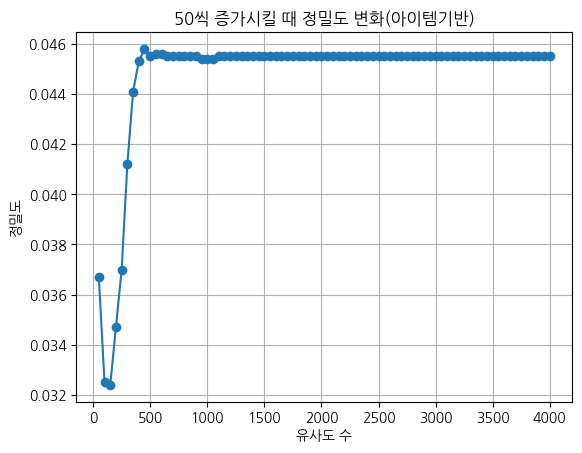

아이템기반 최대 정밀도
450 개의 유사도를 반영할 때 정밀도: 0.0458


In [33]:
x = [entry[0] for entry in Item_param_50]
y = [entry[2]['정밀도'] for entry in Item_param_50]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('50씩 증가시킬 때 정밀도 변화(아이템기반)')
plt.xlabel('유사도 수')
plt.ylabel('정밀도')

# 그래프 표시
plt.grid(True)
plt.show()

print('아이템기반 최대 정밀도')
print(x[np.argsort(y)[-1]],'개의 유사도를 반영할 때 정밀도:',max(y))

### 400~500개

In [35]:
Item_param = []

print(recomm_n,'개 추천')
for i in range(400,501):
    sim = get_topsim(sim_Des, top_n= i)
    pred = pivot_CS.values.dot(sim.values) / np.array([np.abs(sim.values).sum(axis=1)])
    pred = pd.DataFrame(pred, index=pivot_CS.index, columns=pivot_CS.columns)
    result = recomm_model(pred, recomm_n=recomm_n)
    Item_param.append([i,'개의 유사도를 반영할 때',result[3]])
    
print('최대 유사도',max(Item_param, key=lambda x: x[2]['정밀도']))
Item_param

12 개 추천
최대 유사도 [431, '개의 유사도를 반영할 때', {'정밀도': 0.0459}]


[[400, '개의 유사도를 반영할 때', {'정밀도': 0.0453}],
 [401, '개의 유사도를 반영할 때', {'정밀도': 0.0453}],
 [402, '개의 유사도를 반영할 때', {'정밀도': 0.0454}],
 [403, '개의 유사도를 반영할 때', {'정밀도': 0.0453}],
 [404, '개의 유사도를 반영할 때', {'정밀도': 0.0452}],
 [405, '개의 유사도를 반영할 때', {'정밀도': 0.0453}],
 [406, '개의 유사도를 반영할 때', {'정밀도': 0.0453}],
 [407, '개의 유사도를 반영할 때', {'정밀도': 0.0453}],
 [408, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [409, '개의 유사도를 반영할 때', {'정밀도': 0.0454}],
 [410, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [411, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [412, '개의 유사도를 반영할 때', {'정밀도': 0.0455}],
 [413, '개의 유사도를 반영할 때', {'정밀도': 0.0456}],
 [414, '개의 유사도를 반영할 때', {'정밀도': 0.0457}],
 [415, '개의 유사도를 반영할 때', {'정밀도': 0.0457}],
 [416, '개의 유사도를 반영할 때', {'정밀도': 0.0456}],
 [417, '개의 유사도를 반영할 때', {'정밀도': 0.0456}],
 [418, '개의 유사도를 반영할 때', {'정밀도': 0.0456}],
 [419, '개의 유사도를 반영할 때', {'정밀도': 0.0457}],
 [420, '개의 유사도를 반영할 때', {'정밀도': 0.0457}],
 [421, '개의 유사도를 반영할 때', {'정밀도': 0.0458}],
 [422, '개의 유사도를 반영할 때', {'정밀도': 0.0458}],
 [423, '개의 유사도를 반영할 때', {'정밀도': 0.

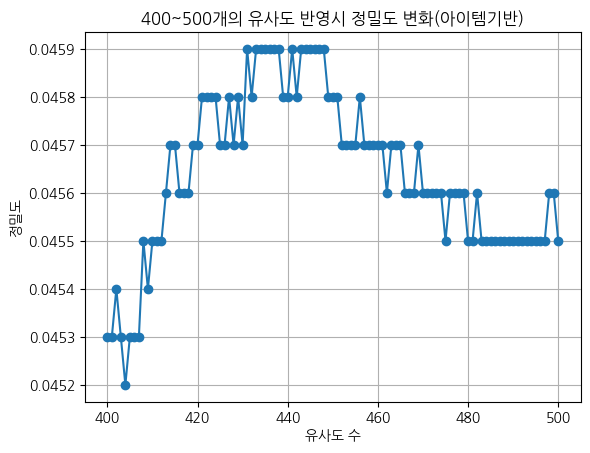

아이템기반 최대 정밀도
436 개의 유사도를 반영할 때 정밀도: 0.0459


In [36]:
x = [entry[0] for entry in Item_param]
y = [entry[2]['정밀도'] for entry in Item_param]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='o')

plt.title('400~500개의 유사도 반영시 정밀도 변화(아이템기반)')
plt.xlabel('유사도 수')
plt.ylabel('정밀도')

# 그래프 표시
plt.grid(True)
plt.show()

print('아이템기반 최대 정밀도')
print(x[np.argsort(y)[-1]],'개의 유사도를 반영할 때 정밀도:',max(y))

## 종합모델
- 주문 유사도 417개 반영
- 고객 유사도 396개 반영
- 아이템 유사도 436개 반영

In [16]:
pred_IS = predict_count(pivot_IS, get_topsim(sim_Inv, top_n = 417), IS = True)
pred_CS = predict_count(pivot_CS, get_topsim(sim_Cust, top_n = 396))

topsim_Des = get_topsim(sim_Des, top_n= 436)
pred_Des = pivot_CS.values.dot(topsim_Des.values) / np.array([np.abs(topsim_Des.values).sum(axis=1)])
pred_Des = pd.DataFrame(pred_Des, index=pivot_CS.index, columns=pivot_CS.columns)

In [44]:
print(recomm_model(pred_IS, recomm_n = recomm_n)[3])
print(recomm_model(pred_CS, recomm_n = recomm_n)[3])
print(recomm_model(pred_Des, recomm_n = recomm_n)[3])

{'정밀도': 0.1179}
{'정밀도': 0.0764}
{'정밀도': 0.0459}


In [17]:
total_param = [] 

# 첫 번째 숫자 선택
for num1 in range(101): #2601번 실행
    # 두 번째 숫자 선택
    for num2 in range(num1 + 1):
        # 세 번째 숫자는 첫 번째와 두 번째 숫자를 뺀 나머지
        num3 = 100 - num1 - num2
        # 세 번째 숫자가 음수가 되면 다음 순서로 넘어감
        if num3 < 0:
            continue

        num_1 = num1/100
        num_2 = num2/100
        num_3 = num3/100

        precision = recomm_model((num_1*pred_IS + num_2*pred_CS + num_3*pred_Des), recomm_n = recomm_n)[3]
        total_param.append(['가중치 비율',[num_1, num_2, num_3], precision])

        print('가중치 비율',[num_1, num_2, num_3], precision)
        
print('\n 최대 정밀도:', max(total_param, key=lambda x: x[2]['정밀도']))


가중치 비율 [0.0, 0.0, 1.0] {'정밀도': 0.0459}
가중치 비율 [0.01, 0.0, 0.99] {'정밀도': 0.0466}
가중치 비율 [0.01, 0.01, 0.98] {'정밀도': 0.0471}
가중치 비율 [0.02, 0.0, 0.98] {'정밀도': 0.0474}
가중치 비율 [0.02, 0.01, 0.97] {'정밀도': 0.0476}
가중치 비율 [0.02, 0.02, 0.96] {'정밀도': 0.0481}
가중치 비율 [0.03, 0.0, 0.97] {'정밀도': 0.0479}
가중치 비율 [0.03, 0.01, 0.96] {'정밀도': 0.0482}
가중치 비율 [0.03, 0.02, 0.95] {'정밀도': 0.0489}
가중치 비율 [0.03, 0.03, 0.94] {'정밀도': 0.0497}
가중치 비율 [0.04, 0.0, 0.96] {'정밀도': 0.0484}
가중치 비율 [0.04, 0.01, 0.95] {'정밀도': 0.049}
가중치 비율 [0.04, 0.02, 0.94] {'정밀도': 0.0498}
가중치 비율 [0.04, 0.03, 0.93] {'정밀도': 0.0504}
가중치 비율 [0.04, 0.04, 0.92] {'정밀도': 0.0512}
가중치 비율 [0.05, 0.0, 0.95] {'정밀도': 0.0491}
가중치 비율 [0.05, 0.01, 0.94] {'정밀도': 0.0497}
가중치 비율 [0.05, 0.02, 0.93] {'정밀도': 0.0503}
가중치 비율 [0.05, 0.03, 0.92] {'정밀도': 0.051}
가중치 비율 [0.05, 0.04, 0.91] {'정밀도': 0.0517}
가중치 비율 [0.05, 0.05, 0.9] {'정밀도': 0.0524}
가중치 비율 [0.06, 0.0, 0.94] {'정밀도': 0.0499}
가중치 비율 [0.06, 0.01, 0.93] {'정밀도': 0.0503}
가중치 비율 [0.06, 0.02, 0.92] {'정밀도': 0.0511}
가중치 

In [18]:
# with open('./data_model/total_param.json', 'w') as json_file:
#     json.dump(total_param, json_file)

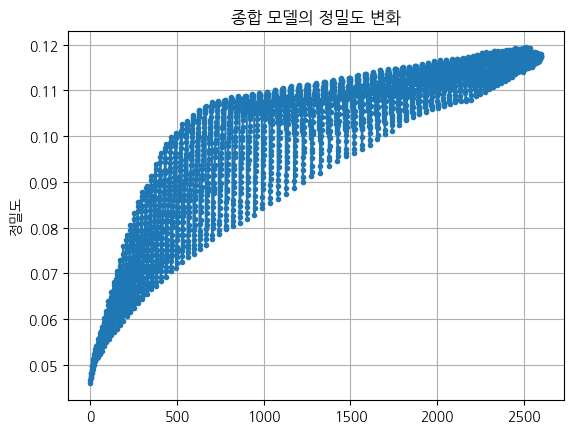

최대 정밀도 0.1194


In [57]:
x = range(len(total_param))
y = [entry[2]['정밀도'] for entry in total_param]

# 꺾은선 그래프 그리기
plt.plot(x, y, marker='.')

plt.title('종합 모델의 정밀도 변화')
plt.xlabel('')
plt.ylabel('정밀도')

# 그래프 표시
plt.grid(True)
plt.show()

print('최대 정밀도',max(y))

## 최종 모델 결정
- 주문 유사도 417개 반영
- 고객 유사도 396개 반영
- 아이템 유사도 436개 반영
- 각각의 가중치 [0.88, 0.0, 0.12] 반영

In [17]:
pred_final = recomm_model((0.88*pred_IS + 0*pred_CS + 0.12*pred_Des), recomm_n = recomm_n)

## 최종모델 검정

### 인기제품 추천

In [18]:
#구매 수량 순, 구매 횟수 순 정렬
top_Quant_prod = train[['StockCode','Quantity']].groupby('StockCode').sum().sort_values(by='Quantity',ascending=False)
top_buy_prod = pd.DataFrame(train['StockCode'].value_counts())

In [22]:
top_buy_prod

,count
StockCode,
85123A,3046
85099B,1693
22423,1633
21212,1540
21232,1383
...,...
90077,1
21838,1
20835,1


#### 이미 구매한 제품 제외, 인기도 순
확연히 낮은 정밀도를 보임을 알 수 있음

In [19]:
def popular_prod_eval(recomm_n = 10, popular_df = top_Quant_prod):
    total_conf_matrix = np.matrix([[0,0],[0,0]])
    shared_customers = set(train['CustomerID'].unique()).intersection(set(test['CustomerID'].unique())) 
    for CustomerID in shared_customers:
        #구매하지 않은 상품 추출
        Customer_info = pivot_CS.loc[CustomerID,]
        unbought_list = Customer_info[Customer_info==0].index

        #구매하지 않은 상품 중 상위 인기 recomm_n개 추천
        unbought_pop_df = popular_df[popular_df.index.isin(unbought_list)]
        recomm_prod = unbought_pop_df[:recomm_n].index

        #평가
        y_test = pd.Series(np.zeros(recomm_n))
        for index, value in enumerate(recomm_prod):
            if value in pivot_test.columns:
                y_test[index] = pivot_test.loc[CustomerID, value]
        y_pred = pd.Series(np.ones(len(recomm_prod)))
        conf_matrix = confusion_matrix(y_test, y_pred) # 혼동 행렬 계산
        if (conf_matrix[0,0] != 0):
            print('<전부 구매함>', f'\nCustomerID: {CustomerID}', f'\nprodcuct: {recomm_prod}')
            total_conf_matrix = total_conf_matrix + [[0,0],[0,conf_matrix[0,0]]]
        else:
            total_conf_matrix = total_conf_matrix + conf_matrix

    FP = total_conf_matrix[0,1]
    TP = total_conf_matrix[1,1]

    precision = np.round(TP / (TP + FP), 4) # 정밀도 계산

    evaluation = {'정밀도': precision}    
    return total_conf_matrix, evaluation

In [ ]:
print(popular_prod_eval(recomm_n=recomm_n,popular_df=top_Quant_prod))
popular_prod_eval(recomm_n=recomm_n,popular_df=top_buy_prod)

(matrix([[    0, 30894],
        [    0,  1602]], dtype=int64), {'정밀도': 0.0493})


(matrix([[    0, 30286],
         [    0,  2210]], dtype=int64),
 {'정밀도': 0.068})

### 최종모델의 추천 제품파악

In [20]:
recomm_final = pred_final[1]

def recomm_test(CustomerID):
    recomm_SC = recomm_final[recomm_final['CustomerID'] == CustomerID[0]]['recommend_products'].explode().tolist()
    recomm_Des = pairs_SD[pairs_SD.index.isin(recomm_SC)]
    recomm_Des.name = 'recomm_prod'
    
    bought_SC = train[train['CustomerID'] == CustomerID[0]]['StockCode'].unique()
    bought_Des = pairs_SD[pairs_SD.index.isin(bought_SC)]
    bought_Des.name = 'bought_prod'

    new_bought_SC = test[test['CustomerID'] == CustomerID[0]]['StockCode'].unique()
    new_bought_Des = pairs_SD[pairs_SD.index.isin(new_bought_SC)]
    new_bought_Des.name = 'new_bought_prod'

    bought_from_recomm = recomm_Des[recomm_Des.isin(new_bought_Des)]
    bought_from_recomm.name = 'bought_from_recomm'
    return recomm_Des, bought_Des, new_bought_Des, bought_from_recomm

In [32]:
import random

# random.seed(1004)
test_ID = random.sample(recomm_final['CustomerID'].tolist(), 1)
print('CustomerID:',test_ID,'\n')

model_test = recomm_test(test_ID) 

print(model_test[0],'\n') #추천제품
print(model_test[1],'\n') #기존 구매 제품
print(model_test[2],'\n') #최근 구매 제품
print(model_test[3]) #추천한 제품 중 구매한 제품

CustomerID: [13330] 

StockCode
20724               [RED SPOTTY CHARLOTTE BAG]
20725                   [LUNCH BAG RED SPOTTY]
20726                     [LUNCH BAG WOODLAND]
21930               [JUMBO STORAGE BAG SKULLS]
21977     [PACK OF 60 PINK PAISLEY CAKE CASES]
22384                [LUNCHBAG PINK RETROSPOT]
22411      [JUMBO SHOPPER VINTAGE RED PAISLEY]
22554       [PLASTERS IN TIN WOODLAND ANIMALS]
22568                  [FELTCRAFT CUSHION OWL]
85099B           [JUMBO BAG RED WHITE SPOTTY ]
85099C        [JUMBO  BAG BAROQUE BLACK WHITE]
85099F                  [JUMBO BAG STRAWBERRY]
Name: recomm_prod, dtype: object 

StockCode
16156S                 [WRAP PINK FAIRY CAKES ]
16161U                  [WRAP,SUKI AND FRIENDS]
20727                 [LUNCH BAG  BLACK SKULL.]
20728                     [LUNCH BAG CARS BLUE]
20971        [PINK BLUE FELT CRAFT TRINKET BOX]
20972      [PINK CREAM FELT CRAFT TRINKET BOX ]
21212        [PACK OF 72 RETRO SPOT CAKE CASES]
21213             [PACK

#### 13330 고객기준

In [27]:
pd.DataFrame(recomm_test([13330])[1]) #기존에 구매한 제품

,bought_prod
StockCode,
16156S,[WRAP PINK FAIRY CAKES ]
16161U,"[WRAP,SUKI AND FRIENDS]"
20727,[LUNCH BAG BLACK SKULL.]
20728,[LUNCH BAG CARS BLUE]
20971,[PINK BLUE FELT CRAFT TRINKET BOX]
20972,[PINK CREAM FELT CRAFT TRINKET BOX ]
21212,[PACK OF 72 RETRO SPOT CAKE CASES]
21213,[PACK OF 72 SKULL CAKE CASES]
21231,[SWEETHEART CERAMIC TRINKET BOX]


In [29]:
pairs_CI[pairs_CI.index == 13330] #13330 고객의 주문 => 498774을 임의로 선택

CustomerID
13330    [498774, 509396, 522048]
Name: InvoiceNo, dtype: object

#### 498774 주문

In [42]:
tmp = sim_Inv[sim_Inv.index == 498774].values[0]
tmp2 = pd.Series(tmp,index=sim_Inv.index)
tmp2.sort_values()

InvoiceNo
489434    0.000000
518354    0.000000
518355    0.000000
518361    0.000000
518370    0.000000
            ...   
505316    0.385077
520703    0.391675
496772    0.410792
497242    0.553912
498774    1.000000
Length: 18192, dtype: float64

In [25]:
display(train.loc[(train['InvoiceNo'] == 498774),['StockCode','Description']])
train.loc[(train['InvoiceNo'] == 497242),['StockCode','Description']]

,StockCode,Description
58515,22367,CHILDS APRON SPACEBOY DESIGN
58516,22380,TOY TIDY SPACEBOY
58517,22381,TOY TIDY PINK RETROSPOT
58518,22382,LUNCHBAG SPACEBOY DESIGN
58519,22383,LUNCHBAG SUKI DESIGN
58520,22384,LUNCHBAG PINK RETROSPOT
58521,47591D,PINK FAIRY CAKE CHILD'S APRON
58522,22385,JUMBO BAG SPACEBOY DESIGN
58523,22386,JUMBO BAG PINK WITH WHITE SPOTS
58524,82580,BATHROOM METAL SIGN


In [58]:
a = pivot_IS.loc[497242,pivot_IS.loc[497242]==1]
b = pivot_IS.loc[498774,pivot_IS.loc[498774]==1]
print(a,'\n')
print(b, '\n')
print(set(a.index)-set(b.index), '\n')

StockCode
20728     1.0
22367     1.0
22380     1.0
22381     1.0
22382     1.0
22383     1.0
22384     1.0
22385     1.0
22386     1.0
47591D    1.0
82580     1.0
Name: 497242, dtype: float64 

StockCode
20728     1.0
20971     1.0
20972     1.0
21212     1.0
21213     1.0
21507     1.0
21509     1.0
21917     1.0
21931     1.0
22029     1.0
22138     1.0
22147     1.0
22149     1.0
22367     1.0
22380     1.0
22381     1.0
22382     1.0
22383     1.0
22385     1.0
22386     1.0
22417     1.0
47591D    1.0
84078A    1.0
84991     1.0
Name: 498774, dtype: float64 

{'82580', '22384'} 



In [29]:
Des_uniq[(Des_uniq.index == '82580')| (Des_uniq.index =='22384')]

22384    LUNCHBAG PINK RETROSPOT
82580        BATHROOM METAL SIGN
dtype: object